#Team
#Chigozie Kenneth Okafor 225983
#Md Khamar Uz Zama 226267
#Rajatha Nagaraja Rao 223758

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [0]:
##Dataset Loading

cifar100 = keras.datasets.cifar100
cifar10 = keras.datasets.cifar10
fashion_mnist = keras.datasets.fashion_mnist
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


#Uncomment the below code to when using the CIFAR dataset
train_labels = train_labels.reshape((-1,))
test_labels = test_labels.reshape((-1,))


data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=60000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, test_labels.astype(np.int32))).batch(100)

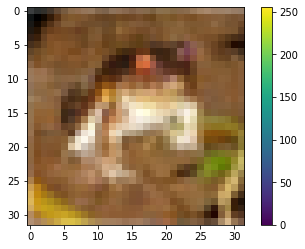

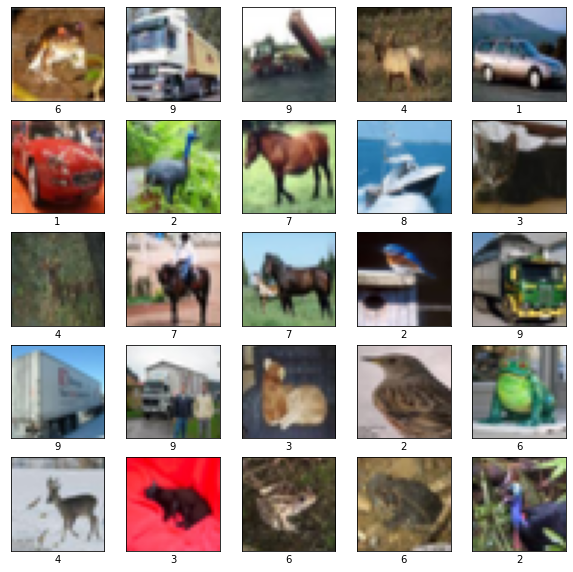

In [0]:
#Visualizng dataset

plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()


In [0]:
##DenseNet with Keras Functional API
inp = tf.keras.layers.Input((32, 32, 3))


def InputLayer(img_input):
      bn_axis = 3
      x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
      x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)
      x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
      x = layers.Activation('elu')(x)
      x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
      x = layers.MaxPooling2D(3, strides=2, )(x)



def DenseBlock(x, growth_rate):
    bn_axis = 3 
    # if backend.image_data_format() == 'channels_last' else 1
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
    x1 = layers.Activation('elu')(x1)
    x1 = layers.Conv2D(8 * growth_rate, 3, padding='same', use_bias=False)(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x1)
    x1 = layers.Activation('elu')(x1)
    x1 = layers.Conv2D(8 * growth_rate, 3, padding='same', use_bias=False)(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x1)
    x1 = layers.Activation('elu')(x1)
    x1 = layers.Conv2D(8 * growth_rate, 3, padding='same', use_bias=False)(x1)
    x = layers.Concatenate(axis=bn_axis)([x, x1])
    return x




def TransitionBlock(x):

    bn_axis = 3 
    # if backend.image_data_format() == 'channels_last' else 1
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
    x = layers.Activation('elu')(x)
    x = layers.Conv2D(16 ,1, use_bias=False)(x)
    x = layers.AveragePooling2D(2, strides=2)(x)
    return x


def FullyConnectedLayer(inputs):
  bn_axis = 1
  x = tf.keras.layers.Flatten()(inputs)
  x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
  return tf.keras.layers.Dense(10)(x)




def DenseNet():
    x = InputLayer(inp)
    x = DenseBlock(inp, 16)
    x = TransitionBlock(x)
    x = DenseBlock(x, 16)
    x = TransitionBlock(x)
    x = DenseBlock(x, 16)
    x = TransitionBlock(x)
    x = DenseBlock(x, 16)
    x = TransitionBlock(x)
    x = DenseBlock(x, 16)
    x = TransitionBlock(x)
    x = DenseBlock(inp, 16)
    x = TransitionBlock(x)
    x = DenseBlock(x, 16)
    x = TransitionBlock(x)
    x = DenseBlock(x, 16)
    x = TransitionBlock(x)
    x = DenseBlock(x, 164)
    x = TransitionBlock(x)
    x = DenseBlock(x, 16)
    x = TransitionBlock(x)
    x = DenseBlock(x, 16)
    x = FullyConnectedLayer(x)
    return x


model = tf.keras.Model(inp, DenseNet())  #Increase the dense block to go deeper


            


opt = tf.optimizers.Adam()

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_acc_metric = tf.metrics.SparseCategoricalAccuracy()

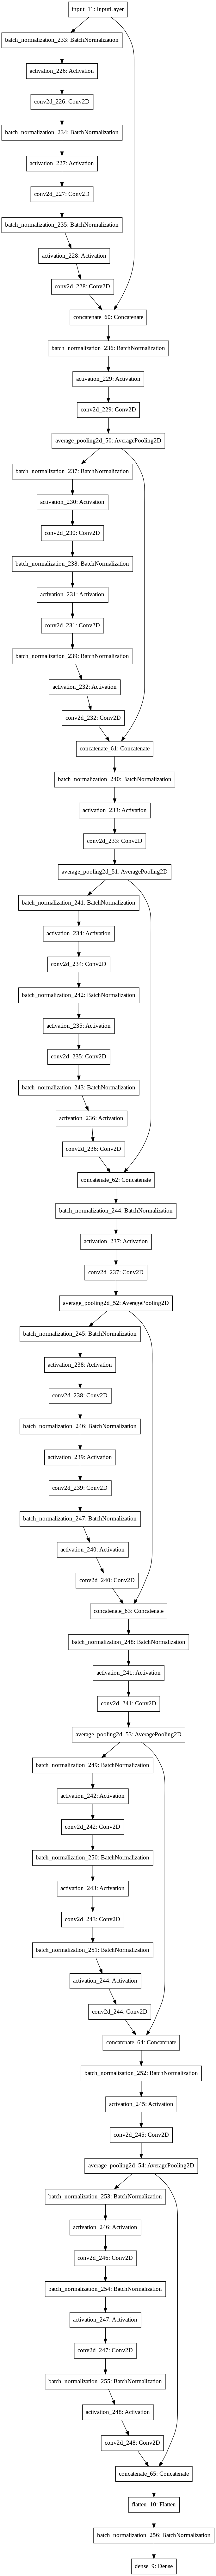

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(model) #, "my_model.png"

In [0]:

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_233 (BatchN (None, 32, 32, 3)    12          input_11[0][0]                   
__________________________________________________________________________________________________
activation_226 (Activation)     (None, 32, 32, 3)    0           batch_normalization_233[0][0]    
__________________________________________________________________________________________________
conv2d_226 (Conv2D)             (None, 32, 32, 128)  3456        activation_226[0][0]             
____________________________________________________________________________________________

In [0]:
# basic training loops can be done like this
model.compile(optimizer=opt, loss=loss_fn, metrics=[train_acc_metric])

In [0]:
model.fit(data, steps_per_epoch=1000, epochs=20)

Epoch 1/20
1000/1000 [==============================] - 355s 355ms/step - loss: 0.1131 - sparse_categorical_accuracy: 0.9599
Epoch 2/20
1000/1000 [==============================] - 355s 355ms/step - loss: 0.0944 - sparse_categorical_accuracy: 0.9668
Epoch 3/20
1000/1000 [==============================] - 354s 354ms/step - loss: 0.0769 - sparse_categorical_accuracy: 0.9732
Epoch 4/20
1000/1000 [==============================] - 355s 355ms/step - loss: 0.0680 - sparse_categorical_accuracy: 0.9764
Epoch 5/20
1000/1000 [==============================] - 354s 354ms/step - loss: 0.0576 - sparse_categorical_accuracy: 0.9797
Epoch 6/20
1000/1000 [==============================] - 355s 355ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9815
Epoch 7/20
1000/1000 [==============================] - 354s 354ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9839
Epoch 8/20
1000/1000 [==============================] - 354s 354ms/step - loss: 0.0422 - sparse_categorical_accuracy: 0.9852


In [0]:
model.evaluate(test_data)

100/100 [==============================] - 10s 102ms/step - loss: 0.7285 - sparse_categorical_accuracy: 0.8121


[0.7285481691360474, 0.8120999932289124]

#Inference

<dl>
  <dt>Model_1</dt>

</dl>

| Activation        | Tranning Accuracy |   Test Accuracy|
| ------------- |:-------------:|:-------------:|
|RELU | 0.72| 0.65|
| ELU | 0.72 |0.66|
| TANH |0.71 |0.62|

********

<dl>
  <dt>Model_2 = len(moedel_1) *2 (Dense Layer now has 3 Convolution layers rather than 2)</dt>

</dl>

| Activation        | Tranning Accuracy |   Test Accuracy|
| ------------- |:-------------:|:-------------:|
|RELU | 0.915| 0.73|
| ELU  |0.92 |0.80|
| TANH | 0.875 |0.72|

*********

<dl>
  <dt>Model_3 =  len(Model_2) * 2</dt>

</dl>

| Activation        | Tranning Accuracy |   Test Accuracy|
| ------------- |:-------------:|:-------------:|
| ELU  |0.92|0.80|

******
<dl>
  <dt>Model_4 =  Model_3 with growth rate 0f 16 </dt>

</dl>

| Activation        | Tranning Accuracy |   Test Accuracy|
| ------------- |:-------------:|:-------------:|
| ELU and Team Management |0.9493 | 0.8121|


NB All other parameters were kept constant



In [0]:
import time
from datetime import datetime
trainSteps = 1000


def Loss_fn (logits,labels):
  xent = loss_fn(labels, logits)
  return xent



def Accuracy(logits, labels):
        train_acc_metric(labels, logits)
        acc = train_acc_metric.result()
        return acc



@tf.function
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        # tape.watch(model.trainable_variables)
        logits = model(x)
        xent = Loss_fn(logits, y)

    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
    optimizer.apply_gradients(zip(grads, varis))
    accuracy = Accuracy(logits, y)

    return xent, accuracy




def train(model, optimizer):
    start = time.time()
    train_ds = data
    step = 0
    for step, (x, y) in enumerate(train_ds):
      if step > trainSteps:
        break

      # Set up logging.
      stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
      logdir = 'logs/func/%s' % stamp
      writer = tf.summary.create_file_writer(logdir)


      # Bracket the function call with
      # tf.summary.trace_on() and tf.summary.trace_export().
      tf.summary.trace_on(graph=True, profiler=True)

      loss, accuracy = train_step(model, optimizer, x, y)

      with writer.as_default():
        tf.summary.trace_export(name="my_func_trace",step=0,profiler_outdir=logdir)


        
      if not step % 100:
          stop = time.time()
          print("Loss: {} Accuracy: {}".format(loss, accuracy))
          train_acc_metric.reset_states()
          print("elapsed {} seconds\n".format(stop-start))
          start = time.time()
    return step



opt = tf.optimizers.Adam()

_ =  train(model, opt)





Loss: 2.311544179916382 Accuracy: 0.1171875
elapsed 4.086256504058838 seconds

Loss: 2.0256271362304688 Accuracy: 0.20929688215255737
elapsed 10.216967344284058 seconds

Loss: 1.8222427368164062 Accuracy: 0.2931250035762787
elapsed 10.398364543914795 seconds

Loss: 1.6619638204574585 Accuracy: 0.36851561069488525
elapsed 10.526326656341553 seconds

Loss: 1.4345728158950806 Accuracy: 0.42409032583236694
elapsed 12.146837711334229 seconds

Loss: 1.4958194494247437 Accuracy: 0.45804688334465027
elapsed 10.499982357025146 seconds

Loss: 1.5941429138183594 Accuracy: 0.48531249165534973
elapsed 10.65284538269043 seconds

Loss: 1.189978003501892 Accuracy: 0.5035156011581421
elapsed 10.691988706588745 seconds

Loss: 1.2152589559555054 Accuracy: 0.5340338945388794
elapsed 10.84902548789978 seconds

Loss: 1.148892879486084 Accuracy: 0.5672656297683716
elapsed 10.53551697731018 seconds

Loss: 1.1724424362182617 Accuracy: 0.5780468583106995
elapsed 10.651903867721558 seconds



In [0]:
test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))

test_acc_metric.result()

print("Test  Accuracy: {}".format(test_acc_metric.result()))

Test  Accuracy: 0.9006999731063843


## Cookie Time

In [0]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import MNISTDataset


In [0]:
import datetime

W1 = tf.Variable(np.random.rand(784, 200), dtype= tf.float32)
b1 = tf.Variable(np.random.rand(1, 200), dtype= tf.float32)
W2 = tf.Variable(np.random.rand(200, 50) , dtype= tf.float32)
b2 = tf.Variable(np.random.rand(1, 50), dtype= tf.float32)
W3 = tf.Variable(np.random.rand(50, 10) , dtype= tf.float32)
b3 = tf.Variable(np.random.rand(1, 10), dtype= tf.float32) 


def experimentThree(img_batch):
# Added three layers and increased the train_steps to 5000
    
    trainSteps = 5000
    learning_rate = 0.01
    train_stats = {}
    train_stats["acc"] = []
    train_stats["steps"] = []
    train_stats["loss"] = []


    z1 = tf.add(tf.matmul(img_batch, W1), b1)
    a1 = tf.nn.relu(z1)

    z2 = tf.add(tf.matmul(a1, W2), b2)
    a2 = tf.nn.relu(z2)

    # Do not change the activation for the last layer
    logits = tf.add(tf.matmul(a2, W3), b3)
    # a3 = tf.nn.softmax(logits)
    #error = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=lbl_batch))
    return logits 


def Loss_fn (logits,labels):
  xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))
  return xent


def acc_fn(x,y):
    z1_test = tf.matmul(x, W1) + b1
    a1_test = tf.nn.relu(z1_test)

    z2_test = tf.matmul(a1_test, W2) + b2
    a2_test = tf.nn.relu(z2_test)
    
    logits_test = tf.matmul(a2_test, W3) + b3
    test_preds = tf.argmax(logits_test, axis=1,output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, y),tf.float32))
    return acc


@tf.function
def train_step(optimizer, x, y):
    with tf.GradientTape() as tape:
        # tape.watch(model.trainable_variables)
        logits = experimentThree(x)
        xent = Loss_fn(logits, y)

    varis = [W1, b1, W2, b2, W3, b3]
    grads = tape.gradient(xent, varis)
    optimizer.apply_gradients(zip(grads, varis))
    accuracy = acc_fn(x,y)

    return xent, accuracy

#data manipulation uses numpy array hence doesnt use tf.function


def train(optimizer):
    time1 = datetime.datetime.now()
    tf.print('start time {}'.format(time1))
    start = time.time()
    train_ds = data
    step = 0
    for step in range(trainSteps):
      x, y = data.next_batch()
    # img_batch, lbl_batch = data.next_batch()
    # for step, (x, y) in enumerate(train_ds):
      if step > trainSteps:
        break

      loss, accuracy = train_step(optimizer, x, y)

      if not step % 100:
          stop = time.time()
          print("Loss: {}, Accuracy: {}".format(loss, accuracy))
          # train_acc_metric.reset_states()
          
          
    
    time2 = datetime.datetime.now()
    tf.print('start time {}'.format(time2))
    print("elapsed {} seconds\n".format(time2-time1))
          
    return step


#select optimizer
opt = tf.optimizers.Adam()

_ =  train(opt)



start time 2020-05-17 21:27:11.313664
Loss: 13854.390625, Accuracy: 0.078125
Starting new epoch...
Starting new epoch...
Loss: 24.70856285095215, Accuracy: 0.369140625
Starting new epoch...
Starting new epoch...
Loss: 4.2923383712768555, Accuracy: 0.6826171875
Starting new epoch...
Loss: 2.687129020690918, Accuracy: 0.75
Starting new epoch...
Starting new epoch...
Loss: 2.6266560554504395, Accuracy: 0.794921875
Starting new epoch...
Starting new epoch...
Loss: 2.5666167736053467, Accuracy: 0.814453125
Starting new epoch...
Loss: 2.0443506240844727, Accuracy: 0.7939453125
Starting new epoch...
Starting new epoch...
Loss: 121.58938598632812, Accuracy: 0.3291015625
Starting new epoch...
Starting new epoch...
Loss: 2.494842767715454, Accuracy: 0.8388671875
Starting new epoch...
Starting new epoch...
Loss: 2.0885090827941895, Accuracy: 0.8837890625
Starting new epoch...
start time 2020-05-17 21:27:35.580921
elapsed 0:00:24.267257 seconds



#Results
The training and testing is 420 times faster or 80% faster - takes about 25 seconds using tf.function whereas without it, it takes about 105 seconds. 

In [0]:

def experimentThree():
# Added three layers and increased the train_steps to 5000
    time1 = datetime.datetime.now()
    tf.print('start time {}'.format(time1))
    train_steps = 5000
    learning_rate = 0.01
    train_stats = {}
    train_stats["acc"] = []
    train_stats["steps"] = []
    train_stats["loss"] = []
    
    W1 = tf.Variable(np.random.rand(784, 200), dtype= tf.float32)
    b1 = tf.Variable(np.random.rand(1, 200), dtype= tf.float32)
    W2 = tf.Variable(np.random.rand(200, 50) , dtype= tf.float32)
    b2 = tf.Variable(np.random.rand(1, 50), dtype= tf.float32)
    W3 = tf.Variable(np.random.rand(50, 10) , dtype= tf.float32)
    b3 = tf.Variable(np.random.rand(1, 10), dtype= tf.float32)    
    
    for step in range(train_steps):
        img_batch, lbl_batch = data.next_batch()
        
        with tf.GradientTape() as tape:

            z1 = tf.add(tf.matmul(img_batch, W1), b1)
            a1 = tf.nn.relu(z1)

            z2 = tf.add(tf.matmul(a1, W2), b2)
            a2 = tf.nn.relu(z2)

            # Do not change the activation for the last layer
            logits = tf.add(tf.matmul(a2, W3), b3)
            # a3 = tf.nn.softmax(logits)
            error = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=lbl_batch))
    
        grads = tape.gradient(error, [W1, b1, W2, b2, W3, b3])
        W1.assign_sub(learning_rate * grads[0])
        b1.assign_sub(learning_rate * grads[1])
        W2.assign_sub(learning_rate * grads[2])
        b2.assign_sub(learning_rate * grads[3])
        W3.assign_sub(learning_rate * grads[4])
        b3.assign_sub(learning_rate * grads[5])        
            
        if not step % 100:
            preds = tf.argmax(logits, axis=1, output_type=tf.int32)
            accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                                 tf.float32))
            print("Loss: {} Accuracy: {}".format(error, accuracy))
            train_stats["acc"].append(accuracy.numpy())
            train_stats["steps"].append(step)  
            train_stats["loss"].append(error.numpy())            
    
    z1_test = tf.matmul(data.test_data, W1) + b1
    a1_test = tf.nn.relu(z1_test)

    z2_test = tf.matmul(a1_test, W2) + b2
    a2_test = tf.nn.relu(z2_test)
    
    logits_test = tf.matmul(a2_test, W3) + b3
    test_preds = tf.argmax(logits_test, axis=1,output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),tf.float32))
    print("Test accuracy: " + str(acc))
    
    
    time2 = datetime.datetime.now()
    tf.print('start time {}'.format(time2))
    print("elapsed {} seconds\n".format(time2-time1))
          
    return train_stats, test_preds, W1, b1, W2, b2, W3, b3

start time 2020-05-17 21:25:22.613458
Loss: 11769.748046875 Accuracy: 0.115234375
Starting new epoch...
Loss: 2.3309056758880615 Accuracy: 0.1064453125
Starting new epoch...
Starting new epoch...
Loss: 2.345276117324829 Accuracy: 0.0888671875
Starting new epoch...
Starting new epoch...
Loss: 2.327023506164551 Accuracy: 0.091796875
Starting new epoch...
Loss: 2.3248727321624756 Accuracy: 0.0986328125
Starting new epoch...
Starting new epoch...
Loss: 2.3172407150268555 Accuracy: 0.1083984375
Starting new epoch...
Starting new epoch...
Loss: 2.3142404556274414 Accuracy: 0.091796875
Starting new epoch...
Loss: 2.3042407035827637 Accuracy: 0.1005859375
Starting new epoch...
Starting new epoch...
Loss: 2.310784339904785 Accuracy: 0.1044921875
Starting new epoch...
Starting new epoch...
Loss: 2.3149359226226807 Accuracy: 0.072265625
Starting new epoch...
Starting new epoch...
Loss: 2.307436227798462 Accuracy: 0.08223684132099152
Starting new epoch...
Loss: 2.3129849433898926 Accuracy: 0.09082

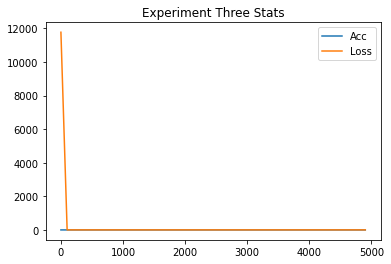

<Figure size 432x288 with 0 Axes>

In [0]:
train_stats3 , test_preds3, W1, b1, W2, b2, W3, b3= experimentThree()
plt.plot(train_stats3["steps"], train_stats3["acc"], label='Acc')
plt.plot(train_stats3["steps"], train_stats3["loss"], label='Loss')
plt.title("Experiment Three Stats")
plt.legend()
plt.show()  
plt.clf()

#Reference 
1. https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/layers/core.py 
2. https://www.kaggle.com/vikramtiwari/tf2-tf-function-and-autograph